In [1]:
import numpy as np
from matplotlib import pyplot as plt

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
from plotting_tools import plotting_f

In [3]:
#PREPARING DATA FOR REGRESSION
#We have some fake (fake) random data representing the properties of the binary
#We relate the quantities in a complicated way that represents the unknown error introduced by GSTLAL
#We want to recover the initial quantities, as the ML algorithm should be able to guess this complicated relation function

np.random.seed(21) #fix random seed so we can reproduce results

#Prepare example dataset:
Nsample=10000 #number of data points
dsample=7 #dimension of the data point DONT CHANGE
    #Example: we have Nsample injections, each of them with dsample parameters estimated
#We will simulate two random masses between 1.1 and 2.1, their two random magnitudes of the spin between 0 and 1, and a random angle between them, from 0 to pi
y=np.zeros((Nsample,dsample))
for i in range (0,Nsample):
    y[i][0:2]=1.1+ np.random.random_sample((1,2)) 
    maxm=np.maximum(y[i][0],y[i][1])
    minm=np.minimum(y[i][0],y[i][1])
    y[i][0]=maxm
    y[i][1]=minm
    y[i][2:4]=np.random.random_sample((1,2)) 
    y[i][4]=np.pi*np.random.random_sample((1,1)) 
    y[i][5]=y[i][0]/y[i][1]  #added mass ratio!
    y[i][6]=(y[i][0]*y[i][1])**(3.0/5)/(y[i][0]+y[i][1])**(1.0/5)    #added chirp mass!

In [4]:
#this emulates the nonlinear effects introduced by the GSTLAL pipeline
def complicated_f(vector):
    x=vector[0]; y=vector[1]; z=vector[2]; w=vector[3]; v=vector[4]
    a=vector[5]; b=vector[6]
    return [x*z+w**2-v/np.sqrt(y)+(1-a)/(b+3), 
            y**3*(a+np.pi*w)/(1+v+3*z), 
            np.sqrt((x-v)**2+(b-w)**2+(z-x)**2), 
            np.sqrt(x+a)/(2*y**2*z+1)+v/(4*y*z*np.sqrt(np.abs(v-b))+2)-w,
            np.sin(x+y)+(a-z)*w/(z+w+v),
            (a**2+(b-y)+x/3)*(z*np.sqrt(w)-v),b]

In [5]:
#We prepare the results "from the pipeline"
errorpct=0.05  #noise percentage to introduce
x=np.zeros((Nsample,dsample));
for i in range (0,Nsample):
    x[i]=complicated_f(y[i])
    for j in range(0, dsample): #plus some random error up to specified % of the value
        x[i][j]=x[i][j]+x[i][j]*(-1)**np.random.randint(1,3)*errorpct*np.random.rand()

In [6]:
#NEW!: dataset only with only mass1 and the chirp mass
y_nomass2=np.delete(y,1,1) #delete m2 column from data
x_nomass2=np.delete(x,1,1)

Then train the ML with data x and tag y, to see if it can discover the complicated function relating the quantities

In [7]:
#Separate into training and tesing sets
training_data = y_nomass2[:7000,:]
testing_data = y_nomass2[7000:,:]

training_noisyd = x_nomass2[:7000,:]
testing_noisyd = x_nomass2[7000:,:]

In [8]:
from sklearn.gaussian_process.kernels import DotProduct, \
            RationalQuadratic, RBF, ConstantKernel as C

In [9]:
%%time
# Method 1
DP = DotProduct()
gpr = GaussianProcessRegressor(kernel=DP, alpha=1e-7, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 2min 3s, sys: 6.77 s, total: 2min 10s
Wall time: 21.1 s


0.8036324225136076

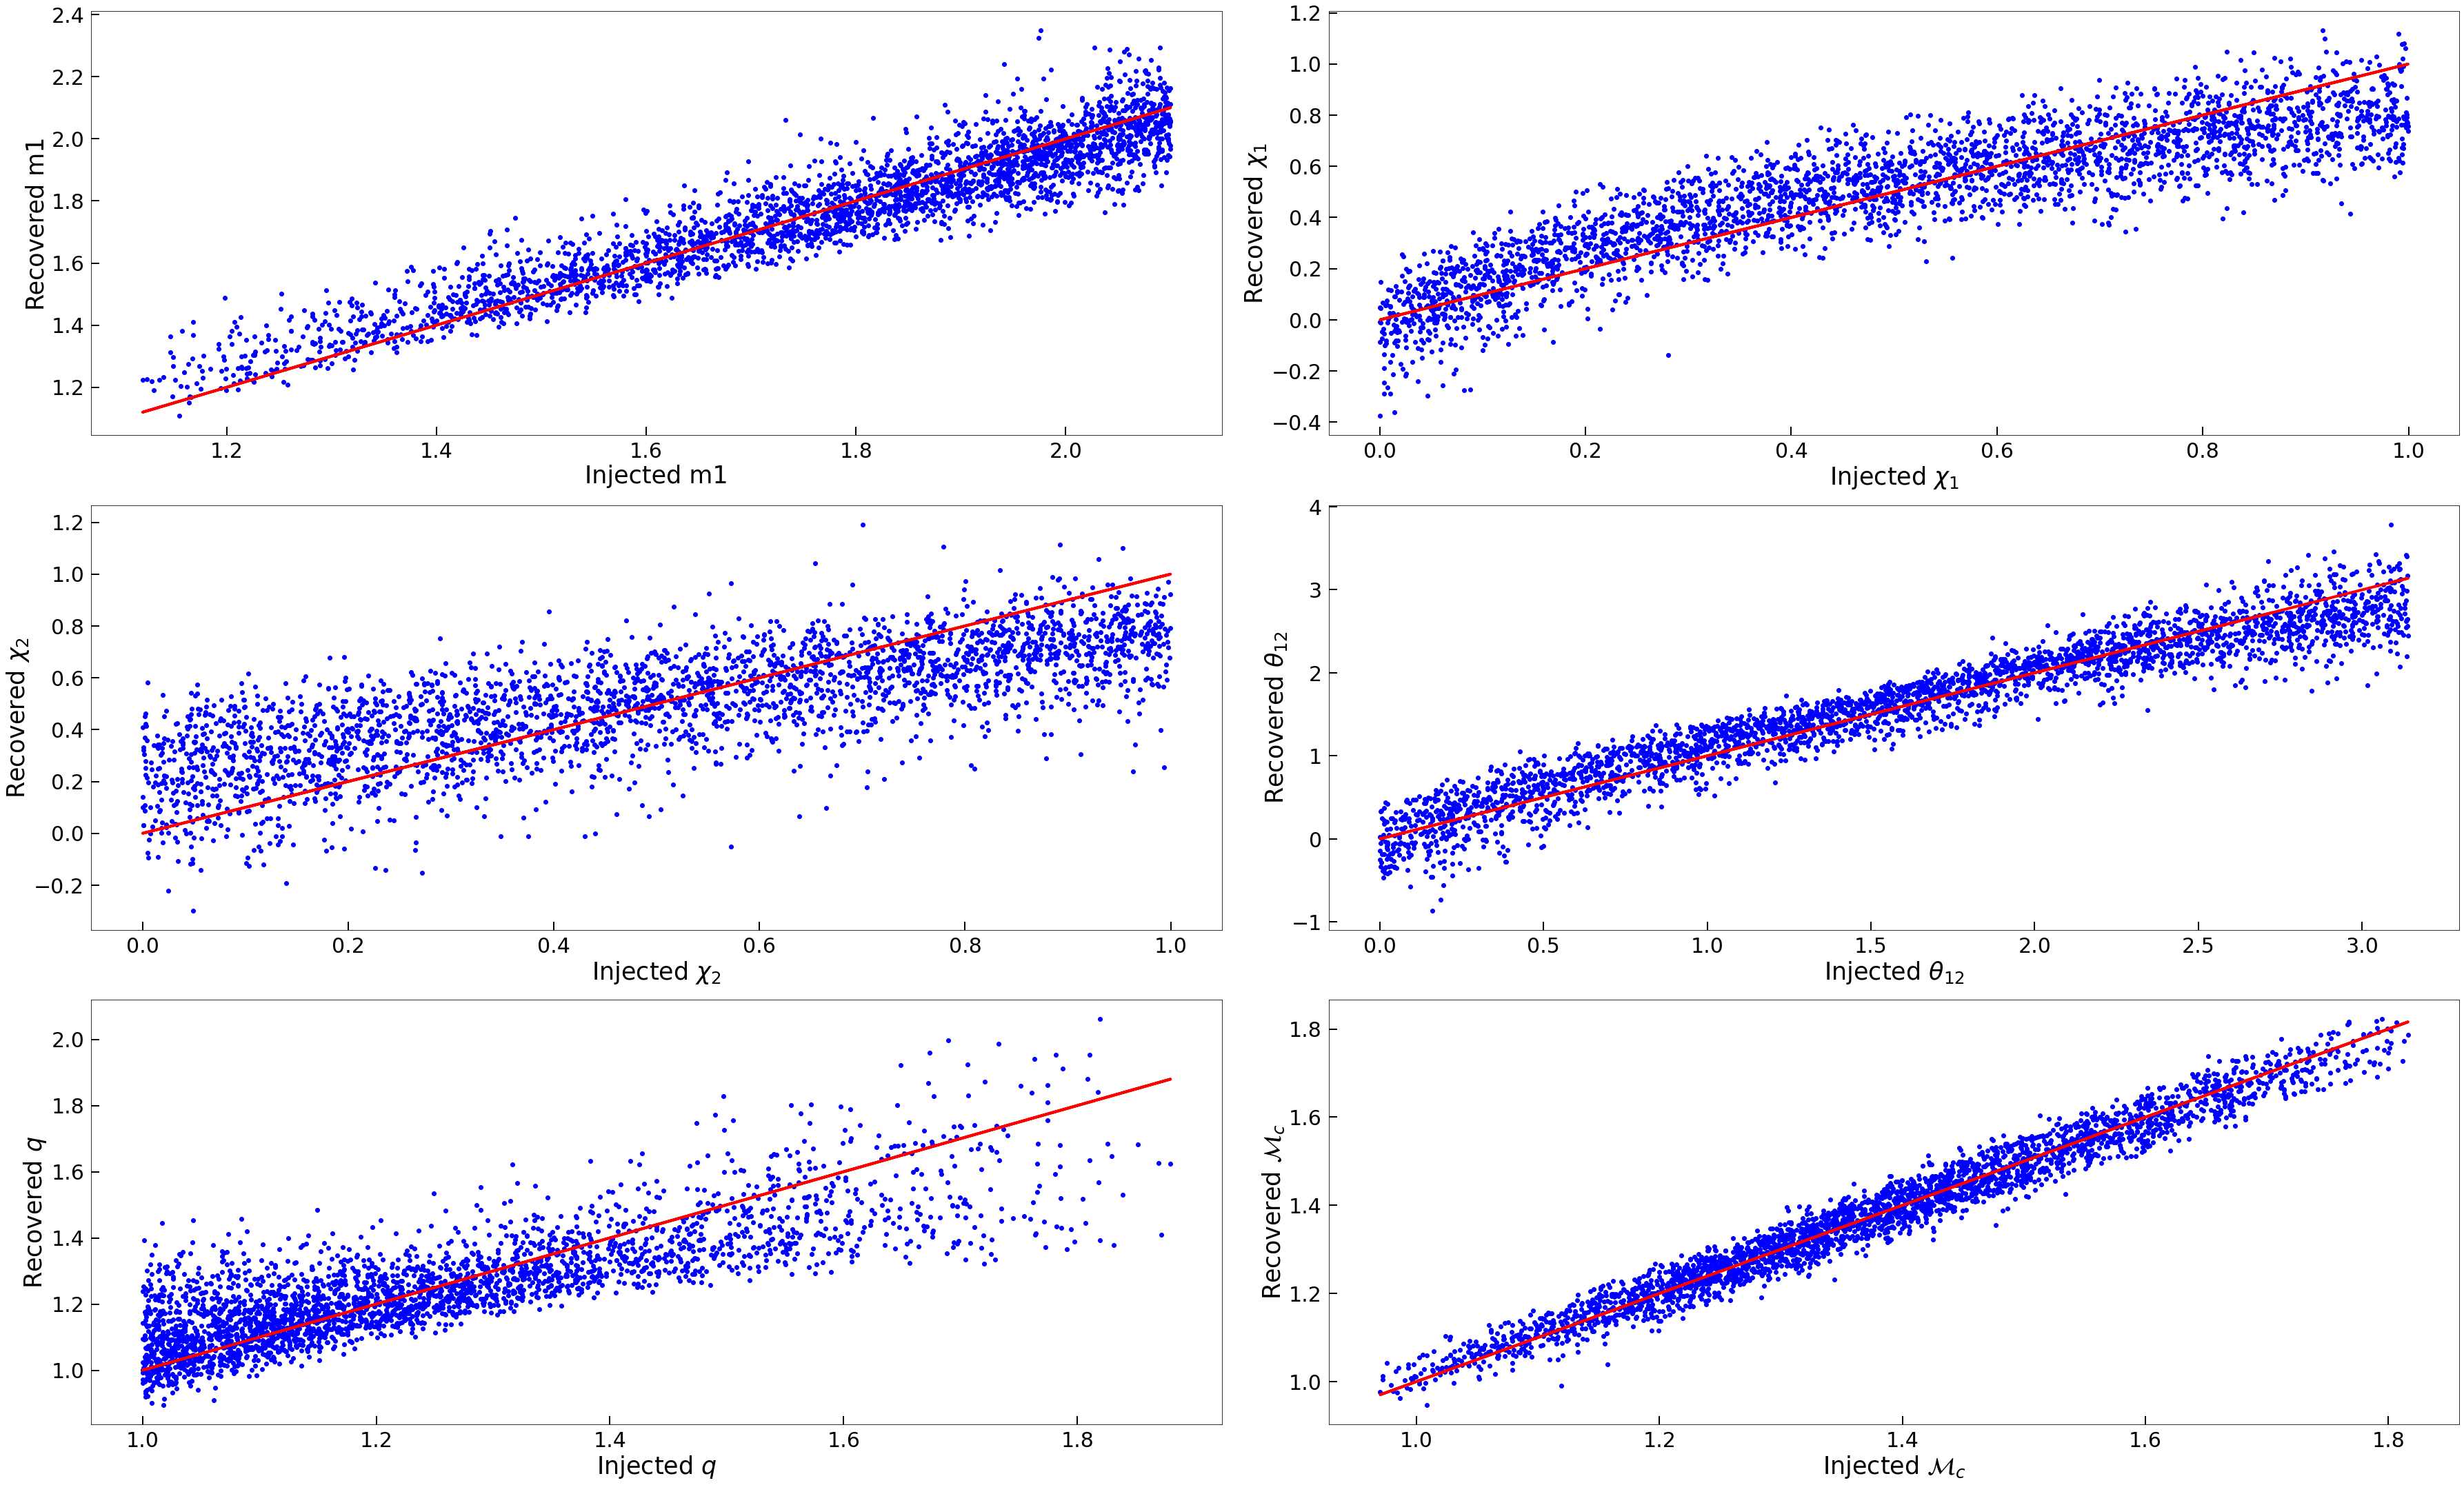

figures/GPR_DP.pdf
Saved figure to figures/GPR_DP.pdf


In [11]:
plotting_f(testing_data, predicted_data, 'DP')

In [12]:
%%time
# Method 2
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-7, n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 38min 58s, sys: 1min 34s, total: 40min 32s
Wall time: 8min 29s


0.49555916091598484

In [ ]:
plotting_f(testing_data, predicted_data, 'RBF_C')

In [13]:
%%time
# Method 3
kernel = RationalQuadratic(length_scale=1.0, alpha=2, length_scale_bounds=(.1, 10), alpha_bounds=(1e-4, 4))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-7, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 22min 41s, sys: 54.6 s, total: 23min 36s
Wall time: 6min 1s


0.9158691740137138

In [ ]:
plotting_f(testing_data, predicted_data, 'RQ')